In [46]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split

In [84]:
epochs = 50
batch_size = 32
learning_rate = 1e-3
val_split = 0.3
num_train_images = 200
num_test_images = 50
num_quantum_filters = 3

quantum_device = qml.device("default.qubit", wires=9)

In [3]:
"""
QUANTUM PART FUNCTIONS
"""

def round_to_power2(x):
    """
    Returns the rounded (by excess) a number to the closest power of 2 
    and the relative power
    e.g. round_to_power2(6) = (8, 3), round_to_power2(9) = (16, 4) 

    used for the number of qbits required in amplitude embeding
    which are log2(features)
    """
    y = np.ceil(np.log2(x))
    return int(2**(y)), int(y)


def float_to_bool(tensor, threshold):
    """
    turns an array of any shape of floats in [0,1] in an array 
    with boolean values in {0,1} given a certain threshold   

    used for basis embedding which requires boolean features
    """
    #where the element is below threshold returns 0, else 1
    tensor = np.where(tensor<=threshold, 0., 1.)

    return tensor
    
    

@qml.qnode(quantum_device)
def quantum_preprocess_layer(
    input, 
    embedding, 
    threshold_basis_embedding=0.65,
    epsilon_ampliture_embedding=0.00000001,
    rotation_angle_embedding='X'):
    

    features = np.ravel(input)
    
    if embedding == 'amplitude':    
        _, num_qbits = round_to_power2(len(features))
        features = np.where(features==0., features+epsilon_ampliture_embedding, features)
        qml.AmplitudeEmbedding(features=features, wires=range(num_qbits), pad_with=0., normalize=True)

    elif embedding == 'basis':
        num_qbits = len(features)
        features = float_to_bool(features, threshold=threshold_basis_embedding)
        qml.BasisEmbedding(features=features, wires=range(num_qbits))

    elif embedding == 'angle':
        num_qbits = len(features)
        features = features*np.pi
        qml.AngleEmbedding(features=features, wires=range(num_qbits), rotation=rotation_angle_embedding)


    else:
        raise Exception("Valid embeddings: basis, angle, amplitude")

    num_single_gates = random.randint(0,num_qbits)
    theta = random.uniform(0, 2*np.pi)
    weights = np.array([[theta for _ in range(num_single_gates)]])
    qml.RandomLayers(weights=weights, wires=range(num_qbits))
    
    return [qml.expval(qml.PauliZ(j)) for j in range(num_qbits)]
   
def quantum_conv(
    image,
    quantum_filters,
    embedding,
    dim_quantum_kernel=3,
    padding='same',
    stride=1,
    activation='relu'):


    if padding == 'same':
        output_tensor = np.empty([image.shape[0], image.shape[1], quantum_filters])
        padded_image = np.pad(image, pad_width=[(1,1), (1,1), (0,0)], constant_values=(0,))

    for i in range(0, image.shape[0], stride):
        for j in range(0, image.shape[1], stride):
            
            input_tensor = padded_image[i:i+dim_quantum_kernel, j:j+dim_quantum_kernel, :]
            
            for qfilter in range(quantum_filters):

                outputs = quantum_preprocess_layer(
                    input_tensor,
                    embedding=embedding)

                output = np.mean(outputs)
                
                if activation == 'relu':
                    output = keras.activations.relu(output).numpy()

                output_tensor[i,j,qfilter] = output
    
    return output_tensor


def quantum_augmentation(dataset, labels, num_quantum_filters, embedding):
    
    augmented_dataset = dataset
    augmented_labels = labels

    for idx in range(len(dataset)):
        
        aug_imgs = quantum_conv(dataset[idx,:,:,:], num_quantum_filters, embedding)
        
        for i in range(aug_imgs.shape[-1]):
            aug_img = np.expand_dims(aug_imgs[:,:,i], axis=(0,3))
            augmented_dataset = np.append(augmented_dataset, aug_img, axis=0)
            augmented_labels = np.append(augmented_labels, [labels[idx]], axis=0)

    return augmented_dataset, augmented_labels

In [100]:
"""
CLASSICAL MODEL FUNCTIONS
"""

def conv_block(
    input,
    num_filters,
    kernel_size=3,
    pool_size=2,
    padding='same',
    dropout=False,
    drop_rate=0.5,
    spatial_drop_rate = 0.3,
    activation='relu',):

    x = layers.Conv2D(
        filters=num_filters,
        kernel_size=kernel_size,
        padding=padding,
        activation=activation,
    )(input)

    x = layers.MaxPooling2D(pool_size=pool_size)(x)

    if dropout == 'classic':
        x = layers.Dropout(drop_rate)(x)
    
    if dropout == 'spatial':
        x = layers.SpatialDropout2D(spatial_drop_rate)(x)
    
    return x


def fc_block(
    input,
    nodes,
    num_layers=1,
    dropout = True,
    drop_rate = 0.5,
    activation = 'relu',
    l2_regularization = True,
    l2_penalty = 1e-3,
):

    x = layers.Flatten()(input)

    for layer in range(num_layers):

        if l2_regularization:
            x = layers.Dense(nodes,
            activation=activation,
            activity_regularizer=keras.regularizers.L2(l2_penalty))(x)

        else:
            x = layers.Dense(nodes,
            activation=activation,)(x)
        
        if dropout:
            x = layers.Dropout(drop_rate)(x)

    return x


def build_model(img_size, num_classes):

    input = keras.Input(shape=(img_size,img_size,1))

    x = conv_block(input, num_filters=16)
    x = conv_block(x, num_filters=32)
    x = fc_block(x, nodes=64, drop_rate=0.6)

    output = layers.Dense(num_classes, activation='softmax')(x)

    return keras.Model(inputs=input, outputs=output)

In [45]:
"""
PLOTTING FUNCTIONS
"""

def plot_loss_metric(loss, val_loss, metric, val_metric, metric_name='accuracy'):

    epochs_range = range(len(loss))

    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    if metric_name == 'accuracy':
        plt.plot(epochs_range, metric, label='Training Accuracy')
        plt.plot(epochs_range, val_metric, label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
    elif metric_name == 'recall':
        plt.plot(epochs_range, metric, label='Training Recall')
        plt.plot(epochs_range, val_metric, label='Validation Recall')
        plt.title('Training and Validation Recall')
    elif metric_name == 'precision':
        plt.plot(epochs_range, metric, label='Training Precision')
        plt.plot(epochs_range, val_metric, label='Validation Precision')
        plt.title('Training and Validation Precision')
    plt.legend(loc='lower right')
    

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

In [ ]:
def prep_dataset(dataset):

    dataset = dataset/255.
    dataset = np.expand_dims(dataset, axis=3)

    return dataset

In [ ]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()

train_images = train_images[:num_train_images]
train_labels = train_labels[:num_train_images]
test_images = test_images[:num_test_images]
test_labels = test_labels[:num_test_images]
train_images = prep_dataset(train_images)
test_images = prep_dataset(test_images)

In [431]:
out = quantum_conv(train_images[0], quantum_filters=5, embedding='angle')

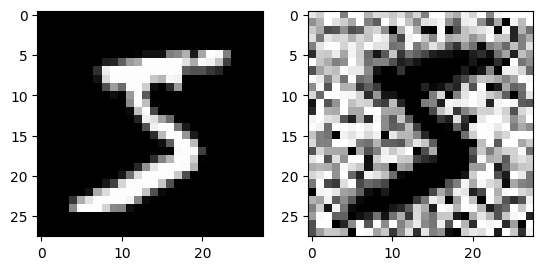

In [434]:
plt.subplot(1,2,1)
plt.imshow(train_images[0], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(out[:,:,0], cmap='gray')

In [86]:
new_dataset, new_labels = quantum_augmentation(train_images, train_labels, num_quantum_filters, embedding='angle')

In [88]:
x_train, x_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.25, random_state=25)

In [ ]:
y_train = keras.utils.to_categorical(y_train)
y_val = keras.utils.to_categorical(y_val)

In [ ]:
loss = keras.losses.CategoricalCrossentropy()
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

model = build_model(28, 10)

model.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=['accuracy']
)

history = model.fit(
    x = x_train,
    y = y_train,
    batch_size=batch_size,
    validation_data=(x_val, y_val),
    epochs=epochs,
    shuffle=False,
)

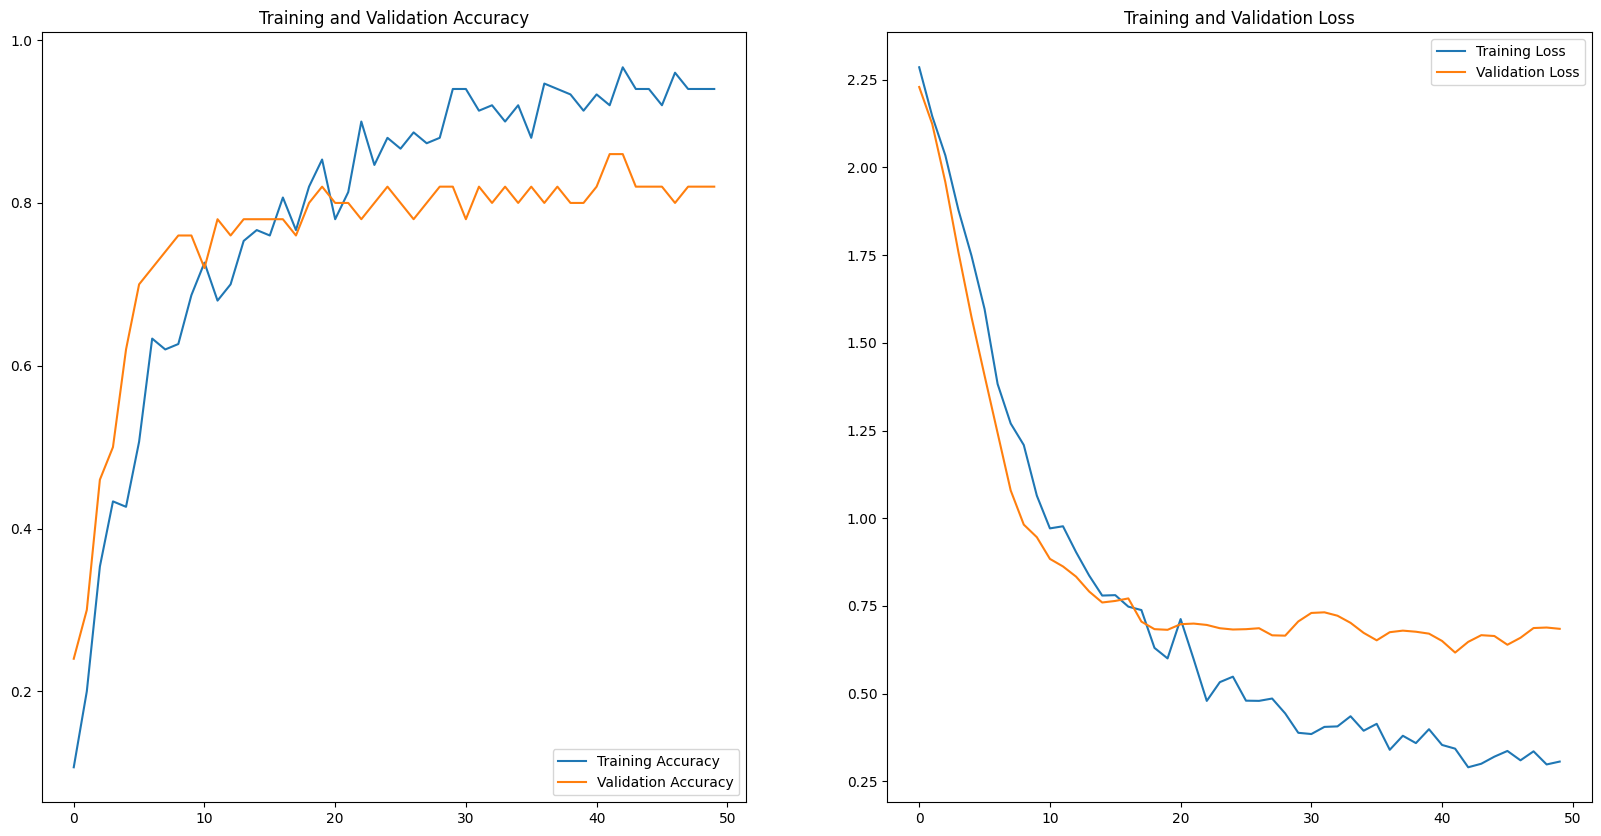

In [104]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plot_loss_metric(loss, val_loss, acc, val_acc)

In [94]:
x_train_q, x_val_q, y_train_q, y_val_q = train_test_split(new_dataset, new_labels, test_size=0.25, random_state=25)

In [95]:
y_train_q = keras.utils.to_categorical(y_train_q)
y_val_q = keras.utils.to_categorical(y_val_q)

In [ ]:
loss = keras.losses.CategoricalCrossentropy()
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

model = build_model(28, 10)

model.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=['accuracy']
)

history_q = model.fit(
    x = x_train_q,
    y = y_train_q,
    batch_size=batch_size,
    validation_data=(x_val_q, y_val_q),
    epochs=epochs,
    shuffle=False,
)

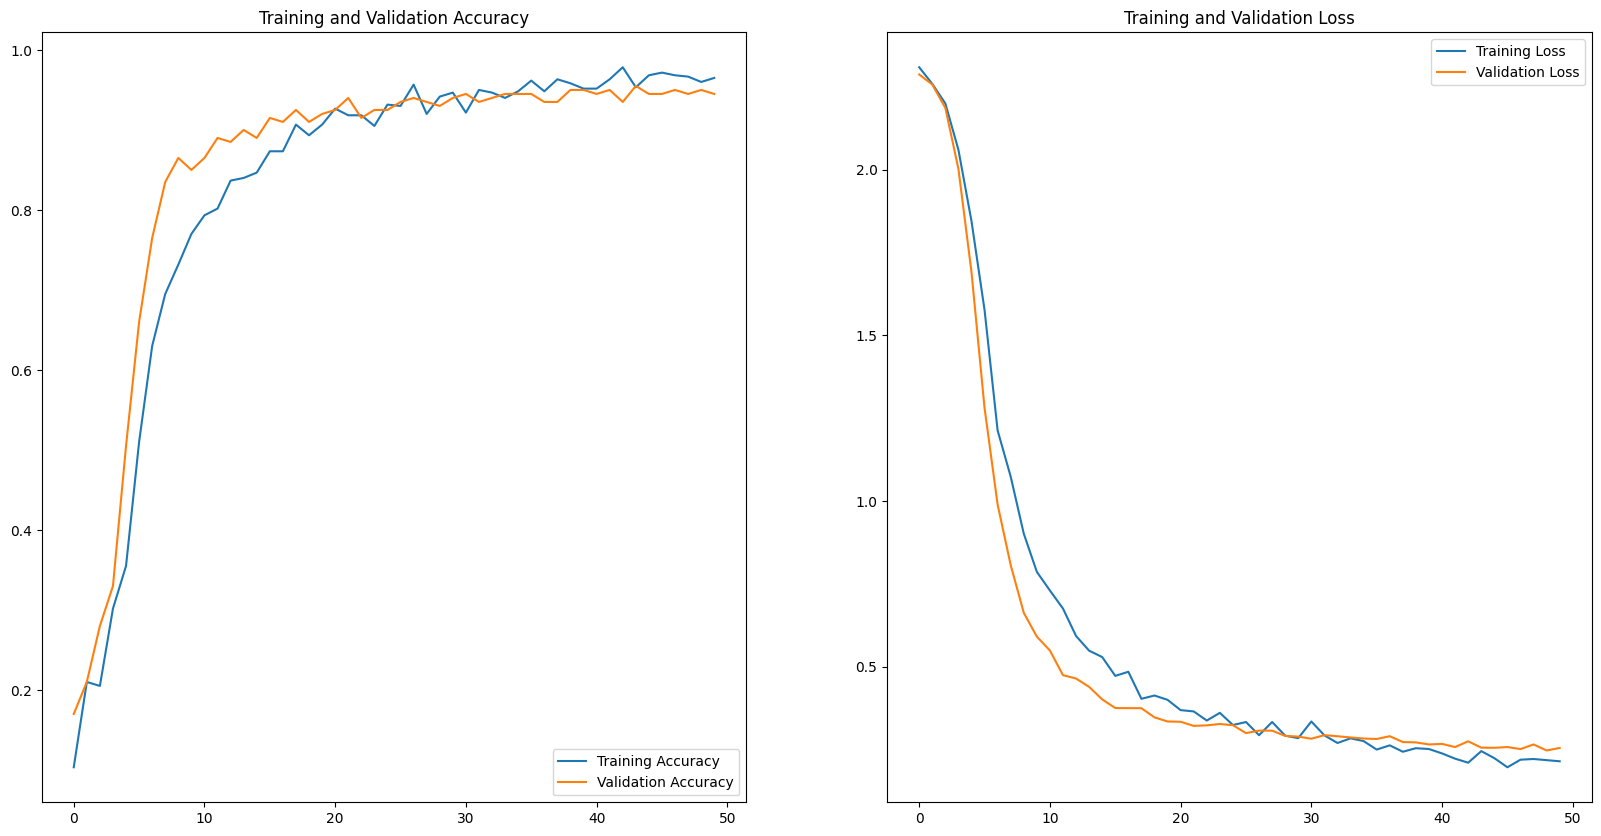

In [102]:
loss = history_q.history['loss']
val_loss = history_q.history['val_loss']
acc = history_q.history['accuracy']
val_acc = history_q.history['val_accuracy']

plot_loss_metric(loss, val_loss, acc, val_acc)